# NLP tools

## Part 1 
#### based on Finnish NLP article:

https://data.solita.fi/finnish-stemming-and-lemmatization-in-python/

The idea is to test around some Finnish NLP tools.

In [1]:
#library import
import libvoikko #https://voikko.puimula.org/ - Finnish NLP library!

In [2]:
#define a voikko class for Finnish
v = libvoikko.Voikko(u"fi")

word = "kissojamme"
#analyze the word
voikko_dict = v.analyze(word)
word_baseform = voikko_dict[0]["BASEFORM"] #the base of the word
print(word_baseform)

kissa


In [8]:
#base forms from text:
txt = "Tähän jotain suomenkielistä tekstiä. Väärinkirjoitettu yhdys-sana, pahus."
print("Original text: ")
print(txt)

#clean the data
txt = txt.lower()
txt = txt.replace(".", "").replace(",","")


bf_list = [] #baseform array
word_list = txt.split(" ") #getting separate words

for w in word_list:
    voikko_dict = v.analyze(w)
    if voikko_dict:
        bf_word = voikko_dict[0]["BASEFORM"]
        
    #if the word is not recognized, and the original word:
    else:
        bf_word = w
    bf_list.append(bf_word)
    
#Results
print("Original words: ")
print(word_list)
print("Lemmatized words: ")
print(bf_list)

Original text: 
Tähän jotain suomenkielistä tekstiä. Väärinkirjoitettu yhdys-sana, pahus.
Original words: 
['tähän', 'jotain', 'suomenkielistä', 'tekstiä', 'väärinkirjoitettu', 'yhdys-sana', 'pahus']
Lemmatized: 
['tämä', 'jokin', 'suomenkieli', 'teksti', 'väärinkirjoitettu', 'yhdys-sana', 'pahus']


## Part 2 
####  done with the help of ChatGPT

The idea is to try a bigger dataset. The dataset can be downloaded here: https://www.kielipankki.fi/lexical-conceptual-resources/wikipedia-fi-2017/

In [9]:
#The original dataset
file_path = "/home/sskky/word2vec/wikipedia-fi-2017-src/wiki_part0.VRT"
with open(file_path, "r", encoding="utf-8") as file:
    lines = file.readlines()
    
    
n = 20 #check the data
sample_lines = lines[:n]
for line in sample_lines:
    print(line)

<doc id="1" url="https://fi.wikipedia.org/wiki?curid=1" title="Amsterdam">

<paragraph>

<sentence>

1	Amsterdam	Amsterdam	PROPN	_	Case=Nom|Number=Sing	0	root	_	_

</sentence>

</paragraph>

<paragraph>

<sentence>

1	Amsterdam	Amsterdam	PROPN	_	Case=Nom|Number=Sing	4	nsubj:cop	_	_

2	on	olla	VERB	_	Mood=Ind|Number=Sing|Person=3|Tense=Pres|VerbForm=Fin|Voice=Act	4	cop	_	_

3	Alankomaiden	Alankomaa	PROPN	_	Case=Gen|Number=Plur	4	nmod:poss	_	_

4	pääkaupunki	pää#kaupunki	NOUN	_	Case=Nom|Number=Sing	0	root	_	_

5	.	.	PUNCT	_	_	4	punct	_	_

</sentence>

<sentence>

1	Amsterdam	Amsterdam	PROPN	_	Case=Nom|Number=Sing	6	nsubj:cop	_	_

2	on	olla	VERB	_	Mood=Ind|Number=Sing|Person=3|Tense=Pres|VerbForm=Fin|Voice=Act	6	cop	_	_

3	väkiluvultaan	väki#luku	NOUN	_	Case=Abl|Number=Sing|Person[psor]=3	6	nmod	_	_

4	Alankomaiden	Alankomaa	PROPN	_	Case=Gen|Number=Plur	6	nmod:poss	_	_

5	suurin	suuri	ADJ	_	Case=Nom|Degree=Sup|Number=Sing	6	amod	_	_



It looked so scary and difficult that instead of cleaning the dataset myself I decided to find a preprossed one.

## Part 3
#### based on chatGPT instructions and this article (but with the Finnish dataset):
https://www.kaggle.com/code/jeffd23/visualizing-word-vectors-with-t-sne/notebook

In [10]:
#libraries:

import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import re #regular expressions
import nltk
from nltk.stem import WordNetLemmatizer

from gensim.models import word2vec

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

#nltk.download("punkt")
#nltk.download('wordnet')

In [11]:
# getting the dataset from wiki fi 

parquet_file = "/home/sskky/word2vec/train1.parquet" #The dataset can be found here: https://huggingface.co/datasets/Finnish-NLP/wikipedia_20230501_fi_cleaned
df = pd.read_parquet(parquet_file) 
df.to_csv('train.csv') #making csv out of parquet format

In [13]:
# analysing the data:
data = pd.read_csv("/home/sskky/word2vec/train.csv").sample(50000, random_state=23)
data_text = data["text"]
print(data_text.head())

In [15]:
#cleaning the data
def clean_sentence(val):
    #removing not letters , downcase
    regex = re.compile('([^\s\w]|_|\d)+')
    sentence = regex.sub('', val).lower()
    sentence = sentence.split(" ")
    
    sentence = " ".join(sentence)
    return sentence



cleaned_data = data['text'].apply(clean_sentence)
print(cleaned_data)

172949    glukoosifosfaatti chop on kemialliselta rakent...
10615     geodesia eli maanmittausoppi on tiede joka mit...
21975     tapahtumia  helmikuuta  keisari constantius ii...
172270    john francis daley s  heinäkuuta  on yhdysvalt...
101010    rotterdamin metro  on alankomaiden toiseksi vä...
                                ...                        
45409     suomen maatalousmuseo sarka on loimaalla varsi...
152434    krymtšakin kieli krymtšakiksi кърымчах тыльы q...
30995     yoyo ma s  lokakuuta  pariisi ranska on yhdysv...
159435    mighty morphin power rangersin  tuotantokautta...
145309    wengemillettia millettia laurentii on afrikkal...
Name: text, Length: 50000, dtype: object


In [17]:
#removing stopwords:
# step one - find the stopword list

def load_stopwords_from_file(file_path):
    with open(file_path, "r", encoding="utf-8") as file:
        stopwords = [line.strip() for line in file] #the stopwords Finnish list can be found here: https://github.com/stopwords-iso/stopwords-fi/blob/master/stopwords-fi.txt
    return set(stopwords)

stopwords_file_path = "/home/sskky/word2vec/stopwords-fi.txt"
stop_words = load_stopwords_from_file(stopwords_file_path)

In [18]:
# step two - remove them from the data
def stop_words_out(text):
    words = words = nltk.word_tokenize(text)
    words = [word for word in words if word.lower() not in stop_words]
    
    cleaned_text = " ".join(words)
    return cleaned_text

cleaned_data = cleaned_data.apply(stop_words_out)
print(cleaned_data)

172949    glukoosifosfaatti chop kemialliselta rakenteel...
10615     geodesia maanmittausoppi tiede mittaa esittää ...
21975     tapahtumia helmikuuta keisari constantius ii m...
172270    john francis daley s heinäkuuta yhdysvaltalain...
101010    rotterdamin metro alankomaiden väkirikkaimman ...
                                ...                        
45409     suomen maatalousmuseo sarka loimaalla varsinai...
152434    krymtšakin kieli krymtšakiksi кърымчах тыльы q...
30995     yoyo ma s lokakuuta pariisi ranska yhdysvaltal...
159435    mighty morphin power rangersin tuotantokautta ...
145309    wengemillettia millettia laurentii afrikkalain...
Name: text, Length: 50000, dtype: object


In [19]:
# lemmatization: nltk 
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    words = nltk.word_tokenize(text)
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return " ".join(lemmatized_words)

cleaned_data = cleaned_data.apply(lemmatize_text)
print(cleaned_data)

172949    glukoosifosfaatti chop kemialliselta rakenteel...
10615     geodesia maanmittausoppi tiede mittaa esittää ...
21975     tapahtumia helmikuuta keisari constantius ii m...
172270    john francis daley s heinäkuuta yhdysvaltalain...
101010    rotterdamin metro alankomaiden väkirikkaimman ...
                                ...                        
45409     suomen maatalousmuseo sarka loimaalla varsinai...
152434    krymtšakin kieli krymtšakiksi кърымчах тыльы q...
30995     yoyo ma s lokakuuta pariisi ranska yhdysvaltal...
159435    mighty morphin power rangersin tuotantokautta ...
145309    wengemillettia millettia laurentii afrikkalain...
Name: text, Length: 50000, dtype: object


In [20]:
#lemmatization with voikko 

def lemmatize_with_voikko(text):
    word_list = nltk.word_tokenize(text)
    
    lemmatized_data = []
    
    for word in word_list:
        voikko_dict = v.analyze(word)
        if voikko_dict:
            baseform_word = voikko_dict[0]["BASEFORM"]
        #if the word is not recognized, and the original word:
        else:
            baseform_word = word
        lemmatized_data.append(baseform_word)
    return " ".join(lemmatized_data)

cleaned_data = cleaned_data.apply(lemmatize_with_voikko)

In [21]:
print(cleaned_data)

172949    glukoosifosfaatti chop kemiallinen rakenne glu...
10615     geodesia maanmittausoppi tiede mitta esittää m...
21975     tapahtuma helmikuu keisari constantius ii määr...
172270    John Francis daley s heinäkuu yhdysvaltalainen...
101010    Rotterdam metro Alankomaa väkirikkaimman kaupu...
                                ...                        
45409     suomi maatalousmuseo sarka Loimaa varsinaissuo...
152434    krymtšakin kieli krymtšakiksi кърымчах тыльы q...
30995     yoyo ma s lokakuu parissa Ranska yhdysvaltalai...
159435    mighty morphin power rangersin tuotantokausi a...
145309    wengemillettia millettia laurentii afrikkalain...
Name: text, Length: 50000, dtype: object


In [22]:
#final lower case (lemmatization dict made some words uppercase!)
cleaned_data = cleaned_data.str.lower()

In [23]:
# word2vec tool
tokenized_text = [sentence.split() for sentence in cleaned_data]
model = word2vec.Word2Vec(sentences=tokenized_text, window=20, min_count=200, workers=4)
model.wv["kaupunki"] #check if we have the vectors

array([-0.7772728 , -0.5572369 , -1.2518675 , -0.6451017 ,  0.06623701,
       -0.04384128, -1.3276483 , -2.8519456 , -0.6189934 , -0.8231555 ,
        3.5943334 ,  1.7610726 , -0.32768098, -3.1993852 ,  0.07849904,
       -0.12679385, -1.4712493 , -2.6198962 ,  0.32645062,  0.27137682,
       -0.35631415, -1.1444287 ,  0.17260912, -3.780632  , -0.5788395 ,
        0.13625345, -1.6831423 , -0.06669553, -2.928439  , -2.5710337 ,
        2.0066082 ,  2.227045  , -1.7859095 ,  0.503818  ,  1.6152982 ,
       -3.8317208 , -0.29527095,  0.87487024, -1.5566716 , -0.3229168 ,
       -5.2474713 , -0.30546618,  0.8667412 , -1.9336826 ,  1.4145513 ,
        0.362053  ,  5.838618  ,  3.8676548 , -0.8158218 ,  0.25850168,
        2.6961968 , -3.2301762 ,  3.0629902 ,  3.1957054 , -0.5794367 ,
       -2.4951053 , -1.1691774 ,  2.7415726 ,  1.3680793 , -2.4314823 ,
       -1.7430853 ,  2.3265634 ,  0.3503914 ,  1.5232992 ,  0.5337522 ,
       -0.98980635,  0.6089636 ,  1.8521475 , -0.9096607 ,  1.14

### Some cool things word vectors can do:

In [24]:
# 1 vector representation of the dataset (and thus - the language)


#plot the model function

def tsne_plot(model, num_words=50, figsize=(15, 15)):
    labels = []
    tokens = []

    for word, _ in model.wv.key_to_index.items():
        vector = model.wv.get_vector(word)
        tokens.append(vector)
        labels.append(word)

    tokens = np.array(tokens)

    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])

    plt.figure(figsize=figsize)
    
    # Zoom in on the plot by setting the axis limits
    plt.xlim(min(x), max(x))
    plt.ylim(min(y), max(y))
    
    for i in range(num_words):
        plt.scatter(x[i], y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords="offset points",
                     ha="right",
                     va="bottom")

    plt.show()




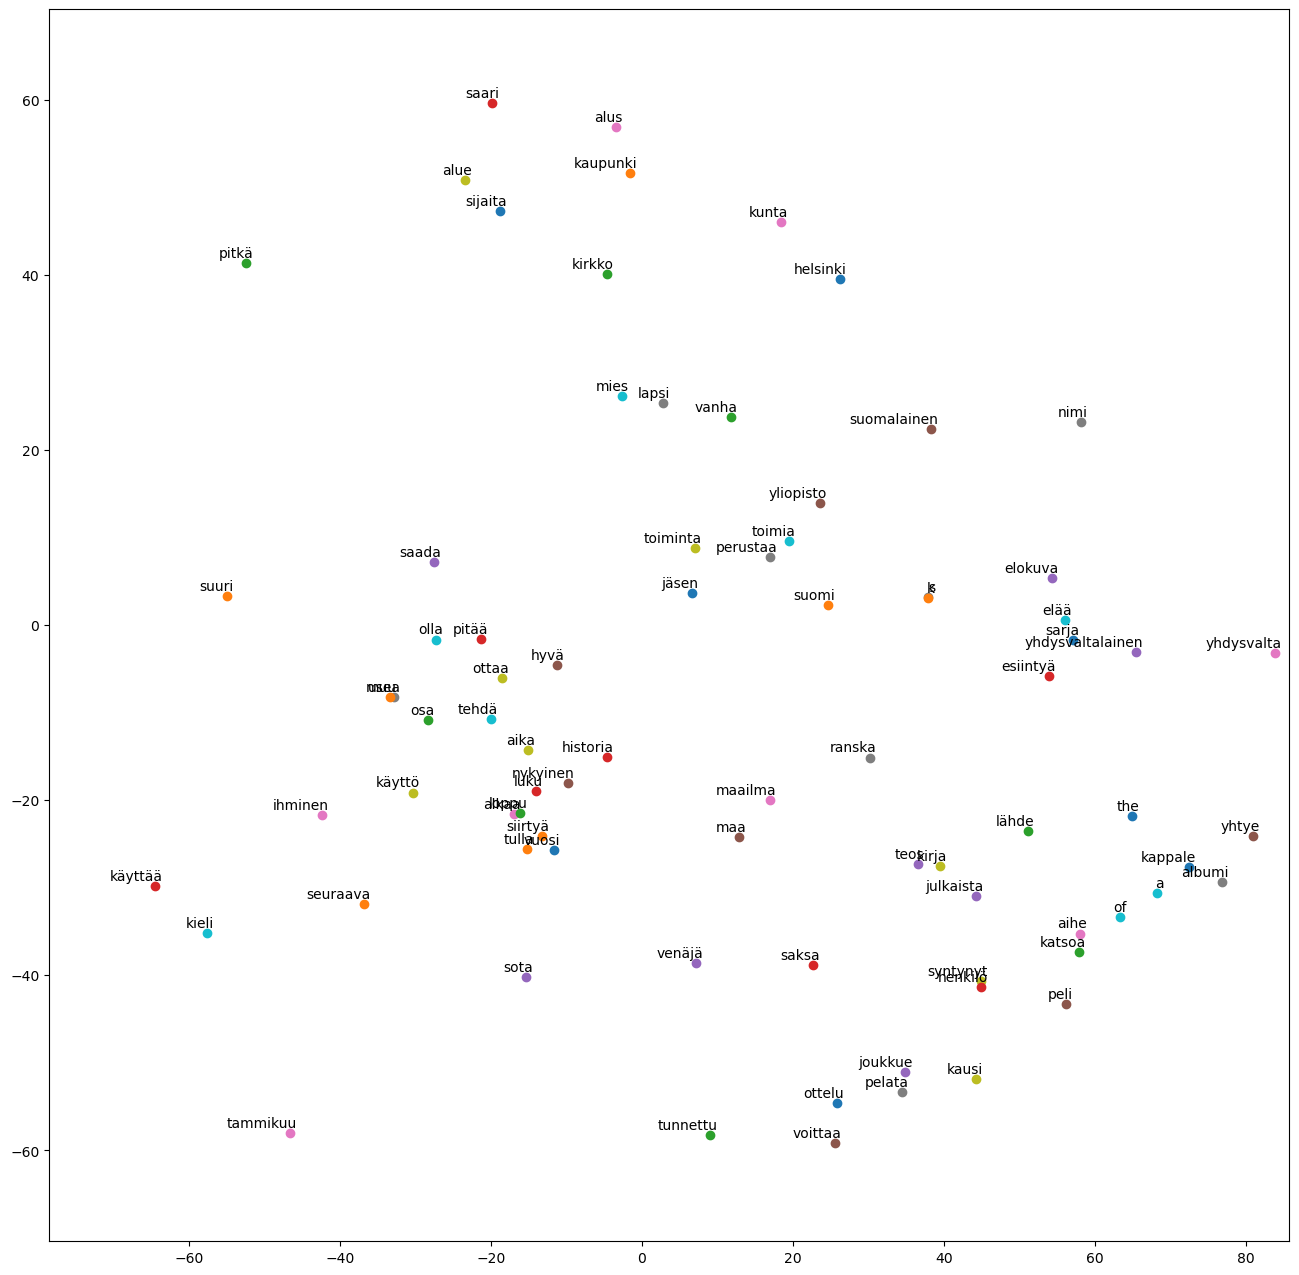

In [25]:
# Example usage (for a small number of data)
tsne_plot(model, num_words=80, figsize=(16, 16))

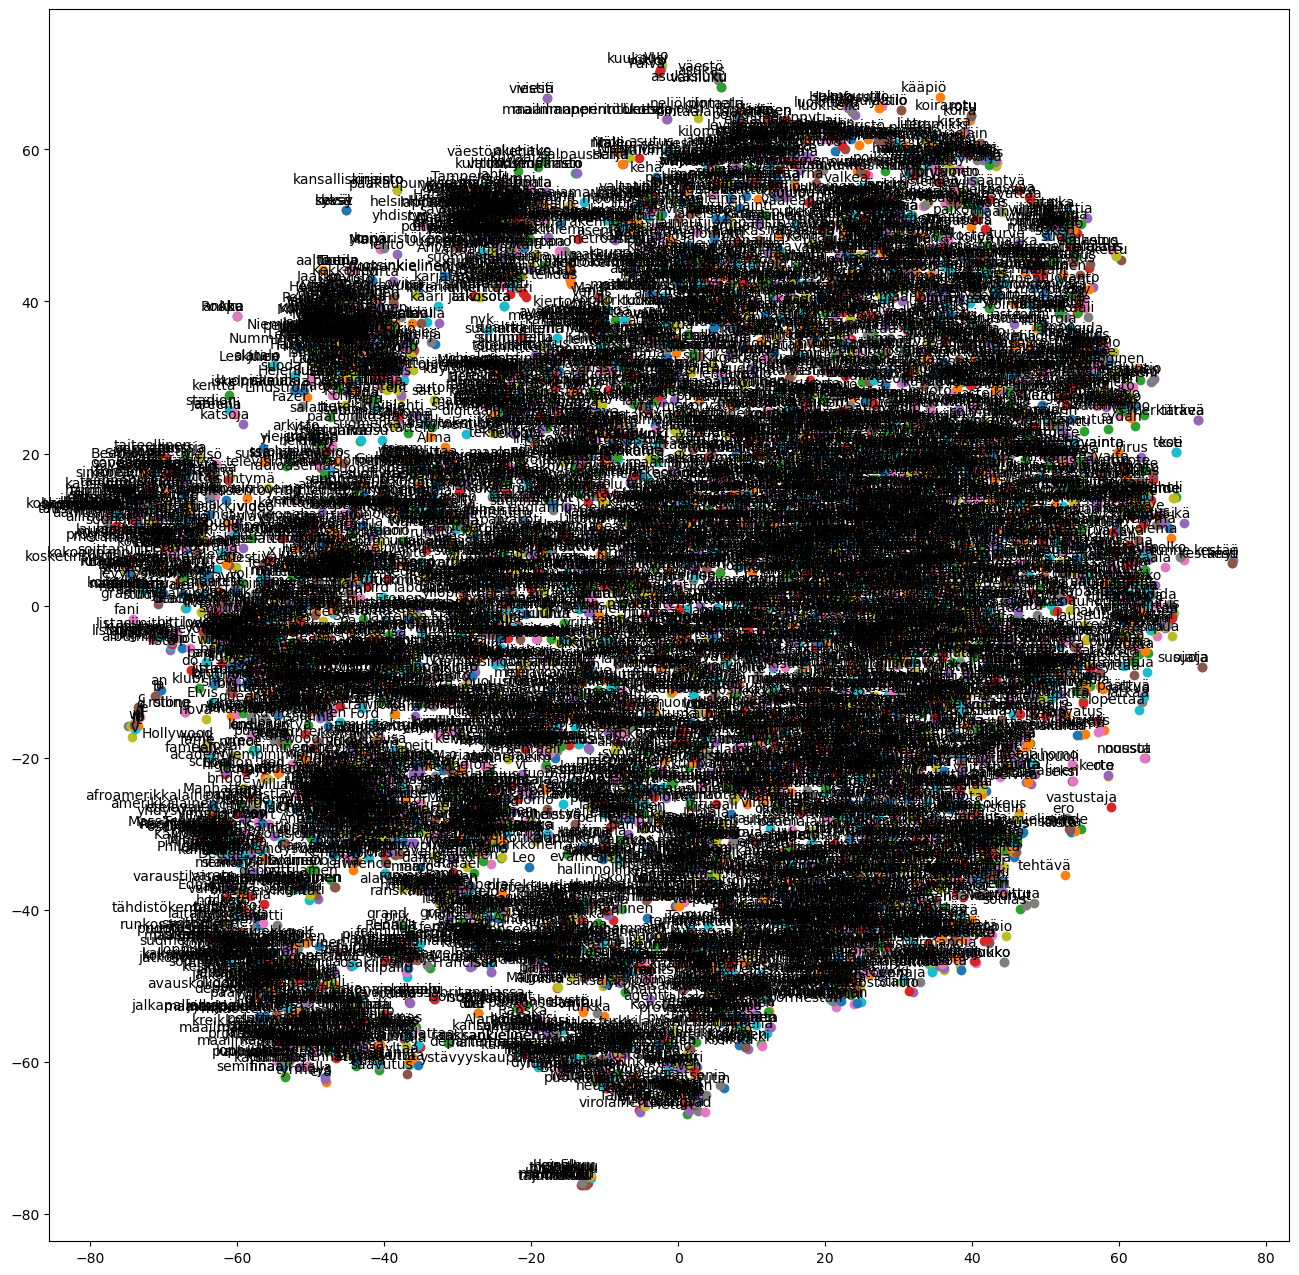

In [94]:
tsne_plot(model) #this will show all the data, but it looks SUPER messy

In [27]:
# 2 word vector arithmetics:

word_to_check = "berliini" #first we need to check if the word IS in the dataset. remember about lower case!
if word_to_check in model.wv.key_to_index:
    print(f"{word_to_check} is in the model")
else: print(f"{word_to_check} is not in the model")

berliini is in the model


In [30]:
classic_example = model.wv.most_similar(positive=['nainen', 'kuningatar'], negative=['kuningas'], topn=1)
city_country_example = model.wv.most_similar(positive=['saksa', 'pariisi'], negative=['berliini'], topn=1)
print(classic_example)
print(city_country_example) 


[('mies', 0.5843008160591125)]
[('ranska', 0.8273261189460754)]


### Another sources used and studied:

* https://aaltodoc.aalto.fi/bitstream/handle/123456789/118320/master_Hatanp%C3%A4%C3%A4_V%C3%A4in%C3%B6_2022.pdf?sequence=1&isAllowed=y
* https://medium.com/@zafaralibagh6/a-simple-word2vec-tutorial-61e64e38a6a1